# Models Calibration
## Kirill Zakharov
2022

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
from functools import partial
from scipy.optimize import minimize, fsolve
import tqdm
import yfinance as yf

%matplotlib inline

plt.style.use('ggplot')

In [98]:
aapl = yf.Ticker('AAPL')

In [108]:
apple_option = aapl.option_chain('2022-03-25').calls

In [112]:
# apple_option.to_csv('Apple_Option.csv')

In [118]:
apple_strikes = apple_option.strike
apple_prices = apple_option.lastPrice

In [7]:
def CallPutOptionPriceCOS(cf, CP, s0, r, tau, K, N, L):
    # L    - size of truncation domain (typ.:L=8 or L=10)  
        
    # reshape K to a column vector
    K = np.array(K).reshape([len(K),1])
    
    i = complex(0.0,1.0) 
    x0 = np.log(s0 / K)   
    
    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  
  
    H_k = Hk_Coefficients(CP,a,b,k)
       
    mat = np.exp(i * np.outer((x0 - a) , u))

    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))
         
    return value

def Hk_Coefficients(CP, a, b, k):
    if str(CP).lower() == "c" or str(CP).lower()=="1":                  
        c = 0.0
        d = b
        coef = Chi_Psi(a, b, c, d, k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k = 2.0 / (b - a) * (Chi_k - Psi_k)  
        
    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        c = a
        d = 0.0
        coef = Chi_Psi(a, b, c, d, k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k

def Chi_Psi(a, b, c, d, k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

In [181]:
CP = 'c'
s0 = 164.7
r = 0.05
# K = [80, 90, 110, 130, 135, 140]
N = 2**8
L = 10
tau = 1
sigma = 0.2

# cf = lambda u: np.exp((r - 0.5 * sigma**2)* 1j * u * tau - 0.5 * sigma**2 * u**2 * tau)

# option_price_cos = CallPutOptionPriceCOS(cf, CP, s0, r, tau, K, N, L)

In [182]:
prices = apple_prices
strikes = apple_strikes

In [183]:
def error_f(x, prices, strikes):
    cf = lambda u: np.exp((x[0] - 0.5 * x[1]**2)* 1j * u * tau - 0.5 * x[1]**2 * u**2 * tau)
    
    price_calib = CallPutOptionPriceCOS(cf, CP, s0, x[0], tau, strikes, N, L).T[0]
    
    return sum(abs(price_calib - prices)/prices)

#r, sigma
init_vals = [0.1, 0.4]
bounds = ((0, 0.1), (-1, 1))

params_BS = minimize(error_f, x0=init_vals, args=(prices, strikes), bounds=bounds, tol=1e-10, options={"maxiter": 10000})
params_BS

      fun: 39.5848626472907
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.85090896e+02, -5.23255750e-01])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 156
      nit: 9
     njev: 52
   status: 2
  success: False
        x: array([ 0.        , -0.10578846])

In [184]:
r = params_BS.x[0]
sigma = params_BS.x[1]

In [185]:
cf = lambda u: np.exp((r - 0.5 * sigma**2)* 1j * u * tau - 0.5 * sigma**2 * u**2 * tau)

option_price_cos = CallPutOptionPriceCOS(cf, CP, s0, r, tau, strikes, N, L)

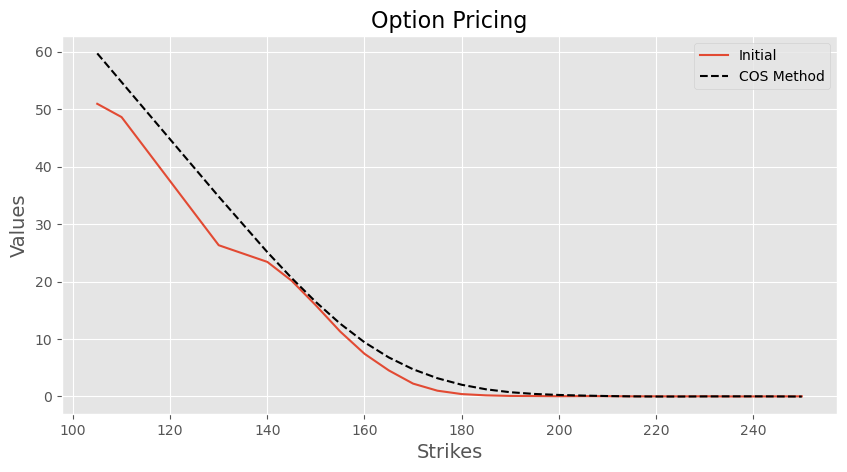

In [186]:
plt.subplots(figsize=(10, 5), dpi=100)
plt.plot(strikes, prices, label='Initial')

plt.plot(strikes, option_price_cos.T[0], '--', color='black', label='COS Method')
        
plt.title('Option Pricing', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()